# Tema 4: Indicadores sintéticos

Antes en ejecutar este código, debe leerse con atención las diapositivas correspondientes al Tema 4 disponibles en el Aula Virtual.

## Ejercicio práctico: replicación de creación del indicador sintético de inversión en equipo ISE

Seguimos el documento metodológico [Metodología de los indicadores sintéticos](https://portal.mineco.gob.es/es-es/economiayempresa/EconomiaInformesMacro/Documents/Documentos%20Metodol%C3%B3gicos/Metodologia%20de%20los%20indicadores%20sint%C3%A9ticos.pdf). Por tanto, es crucial leerse y entender dicho documento.

In [ ]:
# Importamos funciones y establecemos configuración general
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
#from statsmodels.tsa.x13 import x13_arima_analysis # Este método es mejor!
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams["figure.figsize"] = [10,4]  # Default figure size
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

In [ ]:
# Importamos y procesamos datos mensuales
path_data="C:/Users/danie/OneDrive - Universidad Pablo de Olavide de Sevilla/ECO/TEACHING/2025-2026/CyP/Temario/T4/" 
df = pd.read_csv(path_data+"DATOS_ISE.csv", sep=";")
df=df[1:]
df['SERIES']=df.SERIES.astype(str) # convertimos formato texto
df['SERIES']=df.SERIES.str[:4]+"-"+df.SERIES.str[-2:] # Le doy el formato deseado
df['SERIES']=pd.to_datetime(df.SERIES) # Convierto a datetime
df.set_index('SERIES',inplace=True)
df=df.loc["1996-01":"2025-09"] # Para octubre y noviembre no hay datos para algunos indicadores (podría estimarse con SARIMA)
df=df.astype(float)
# Eliminamos columna innecesaria
del df['MATRICULACIONES DE VEHICULOS DE CARGA (ANFAC)']
# Renombramos columnas
df.columns=['ipi', 'ventas', 'matric', 'exp', 'imp']
df

In [ ]:
# Importamos y procesamos datos trimestrales 
path_data="C:/Users/danie/OneDrive - Universidad Pablo de Olavide de Sevilla/ECO/TEACHING/2025-2026/CyP/Temario/T4/" 
cntr = pd.read_excel(path_data+"CNTR_fbcf_equipo.xlsx")
cntr=cntr[8:-9]
cntr.columns=['periodo','inv_equi']
# Preparar la columna periodo con este formato XXXXQX y la podemos con index
cntr['periodo']=cntr.periodo.astype(str) # convertimos formato texto
cntr['periodo']=cntr.periodo.str[:4]+"Q"+cntr.periodo.str[-1:] # Le doy el formato deseado
cntr['periodo']=pd.to_datetime(cntr.periodo) # Convierto a datetime
cntr.set_index('periodo',inplace=True) # Establezco el la columna con index
cntr=cntr.astype(float)

### Paso 1
Seleccionar los indicadores parciales o elementales que resultan representativos de la evolución del PIB, se anualizan y calculan la correlación entre las tasas de variación de cada indicador y la macromagnitud, seleccionando finalmente aquellos con una correlación mayor.

In [ ]:
# ANUALIZAMOS LAS SERIES
cntra=cntr.resample("YE").mean()
dfa=df.resample("YE").mean()
dfa=dfa["1996":"2024"] # Periodo con datos anuales completos disponibles
cntra=cntra["1996":"2024"]

In [ ]:
# CALCULAMOS TASAS DE VARIACIÓN ANUAL Y CORRELACIONES
    # Tasas de variación
dfa_tv=dfa/dfa.shift(1)-1
cntra_tv=cntra/cntra.shift(1)-1
    # Correlaciones 
corr_ipi=np.corrcoef(cntra_tv['inv_equi'].dropna(),dfa_tv['ipi'].dropna())[0,1]
corr_ventas=np.corrcoef(cntra_tv['inv_equi'].dropna(),dfa_tv['ventas'].dropna())[0,1]
corr_matric=np.corrcoef(cntra_tv['inv_equi'].dropna(),dfa_tv['matric'].dropna())[0,1]
corr_exp=np.corrcoef(cntra_tv['inv_equi'].dropna(),dfa_tv['exp'].dropna())[0,1]
corr_imp=np.corrcoef(cntra_tv['inv_equi'].dropna(),dfa_tv['imp'].dropna())[0,1]

print("corr_ipi: ", corr_ipi)
print("corr_ventas: ", corr_ventas)
print("corr_matric: ", corr_matric)
print("corr_exp: ", corr_exp)
print("corr_imp: ", corr_imp)

### Paso 2: Extraemos la serie corregida de estacionalidad y calendario
De cada indicador parcial seleccionado en el paso 1, se extrae la serie corregida de variaciones estacionales y de efectos deterministas (calendario y datos atípicos) (“CVEC”) aplicando el programa TRAMO-SEATS.

In [ ]:
# VARIABLES MENSUALES
df_des=df.copy()
for v in df.columns:
    modelo = sm.tsa.STL(df[v], seasonal=13, robust=True).fit()
    df_des[v]=df[v]-modelo.seasonal

### Paso 3
Una vez seleccionados los indicadores parciales, sus respectivas series se expresan en forma de índice con base 1996. Posteriormente, el indicador sintético se obtiene como suma ponderada de los indicadores parciales que lo integran (series CVEC), siendo las ponderaciones proporcionales a la correlación simple existente entre la macromagnitud que se pretende medir y el indicador parcial correspondiente. Las ponderaciones han sido normalizadas de modo que su suma sea igual a la unidad.

In [ ]:
# SERIES EN ÍNDICE CON BASE 1996
indices=df_des/df_des.iloc[0]

In [ ]:
# CREACIÓN DEL ÍNDICE SINTÉTICO (IS)
    # Normalizamos las ponderaciones (esto podría hacerse usando dict o listas, pero sería algo más complejo).
corr_suma=corr_ipi+corr_ventas+corr_matric+corr_exp+corr_imp
corr_ipin=corr_ipi/corr_suma
corr_ventasn=corr_ventas/corr_suma
corr_matricn=corr_matric/corr_suma
corr_expn=corr_exp/corr_suma
corr_impn=corr_imp/corr_suma
print("¿Suma 1?", corr_ipin+corr_ventasn+corr_matricn+corr_expn+corr_impn)

 # Creamos índice

IS=corr_ipin*indices["ipi"]+ \
    corr_ventasn*indices["ventas"]+ \
    corr_matricn*indices["matric"]+ \
    corr_expn*indices["exp"]+ \
    corr_impn*indices['imp']
    
# Plot para comparar el IS con la macromagnitud que queremos capturar
fig,ax=plt.subplots()
IS.plot(c='r',ax=ax)
cntr.plot(c='b',secondary_y=True,ax=ax)
plt.show()

### Paso 4
Se estima el Indicador Sintético Ajustado, que corrige el problema de escala que aparece como consecuencia de la elevada variabilidad del IS respecto a la macromagnitud.

In [ ]:
# Calculo de ISAj: (1) Anualizacion de IS y cálculo de tasas de variación anual
ISan=IS.resample("YE").mean()
ISan_tv=ISan/ISan.shift(1)-1

In [ ]:
# Regresión lineal entre cntra_tv.fbcf1b["2006":"2018"] y  ISan_tv
y=cntra_tv["1997":"2024"]
x1=ISan_tv["1997":"2024"]
x1=sm.add_constant(x1)
results = sm.OLS(y,x1).fit()
results.summary()

In [ ]:
# Cálculo de TMIS y TMISAJ
tmis=IS/IS.shift(1)-1
tmisaj=1/12*0.0006 + 0.7412*tmis

### Paso 5
Considerando enero de 1996=100 y aplicando sucesivamente las TMISAJt, se obtenen los IS Ajustados (ISAJ). Estos indicadores son, en realidad, el resultado de aplicar un cambio de origen y escala a las tasas de crecimiento de los IS originales, paliando así las diferencias de amplitud observadas entre los IS sin ajustar y las variables contables.

In [ ]:
# ISAJ
ISAJ=IS["1996-01":"2025-09"].copy()
ISAJ["1996-01-01"]=100
x=100
for p in ISAJ[1:].index:
    ISAJ[p]=x*(1+tmisaj[p])
    x=ISAJ[p]
# Por fin lo tenemos y lo podemos dibujar junto a la macromagnitud de referencia
fig,ax=plt.subplots()
ISAJ.plot(ax=ax)
cntr["1996-09":"2025-09"].plot(ax=ax)  # uso "fbcf1a" porque está ajustada
plt.show()

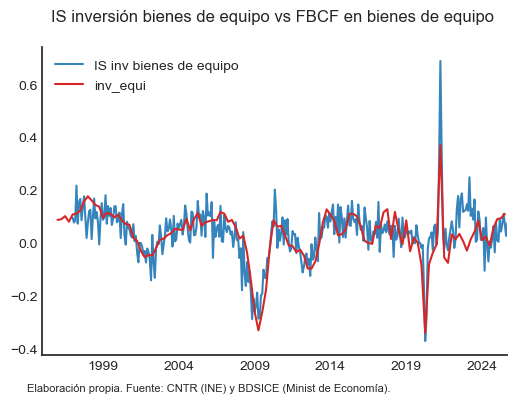

In [49]:
# Finalmente, dibujamos un gráfico de mayor calidad las tasas de variación interanuales
ISAJ_tva=ISAJ/ISAJ.shift(12)-1  # datos mensuales 
cntr_tva=cntr/cntr.shift(4)-1  # datos trimestrales

plt.style.use("seaborn-v0_8-white")
fig,ax=plt.subplots(dpi=100, figsize=(6,4))
ISAJ_tva.plot(ax=ax, alpha=0.9, label="IS inv bienes de equipo")
cntr_tva.plot(ax=ax, color="tab:red", label="FBCF equipo")
ax.legend()
ax.spines[["top","right"]].set_visible(False)
ax.set_title("IS inversión bienes de equipo vs FBCF en bienes de equipo \n", size=12)
ax.set_xlabel("")
fig.text(0.1,0.02,"Elaboración propia. Fuente: CNTR (INE) y BDSICE (Minist de Economía).",size=8)
plt.show()
